In [727]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
from wordcloud import WordCloud
import re
import plotly
import seaborn as sns
import stanza
import string 
import joblib
from scipy.stats import pearsonr


from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

## Reviews download
https://pypi.org/project/steamreviews/

In [728]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [729]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [730]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [731]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [732]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
32057,Little Nightmares II,P,76561199093219492,4,Master Piece...,0.581749081611633301,True,227,1037,69,1705078468
12107,RimWorld,S,76561197993869831,2,A truly great sandbox game and colony simulato...,0.549549520015716553,True,628,31348,34,1669168235
21659,Katana ZERO,A,76561198306123137,103,"Yeah, that should work",0.837453544139862061,True,0,745,5,1633161073
30656,Slay the Spire,R,76561198133060774,1,inspired,0.523809552192687988,True,0,5280,17,1676687997
2549,Sea of Thieves,A,76561198043615182,4,PvE servers yet?,0.552238762378692627,False,334,1783,21,1688653988


In [733]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [734]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [735]:
df.duplicated(subset='review').sum()

2580

In [736]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
16781,Hearts of Iron IV,S,76561198276114952,1,Good,0.520201981067657471,True,0,58949,3,2023-04-16 12:17:00
23958,Left 4 Dead 2,A,76561198870858359,1,good game,0.523809552192687988,True,46,232,3,2023-01-01 07:13:31
16088,Hearts of Iron IV,S,76561199375645681,1,best game,0.523809552192687988,True,14,395,2,2023-02-18 18:21:57
27131,Portal 2,P,76561198985623069,1,p,0.523809552192687988,True,0,299,14,2022-11-28 18:46:29
20529,Factorio,S,76561199041498576,1,fun,0.52173912525177002,True,0,1395,2,2023-01-16 21:37:16
21483,Katana ZERO,A,76561197964094334,2,Yes.,0.52173912525177002,True,0,692,72,2022-12-11 19:05:24
30632,Slay the Spire,R,76561198063573203,1,.,0.523809552192687988,True,109,512,17,2023-03-23 16:39:32
12870,RimWorld,S,76561198354844469,1,good,0.523809552192687988,True,0,15699,1,2023-04-02 18:39:03
15145,Hearts of Iron IV,S,76561198036629241,100,⠀,0.714120447635650635,True,1770,148,1877,2022-10-20 10:08:06
14567,INSIDE,P,76561199352163243,25,If you're looking for a review on this game yo...,0.569113194942474365,True,229,207,26,2023-01-27 12:38:05


In [737]:
(df.duplicated(subset='review') == False).sum()

29492

In [738]:
df = df[df.duplicated(subset='review') == False]

In [739]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [740]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [741]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [742]:
df = df[df["temp_review_len"] >= 3]

In [743]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [744]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [745]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

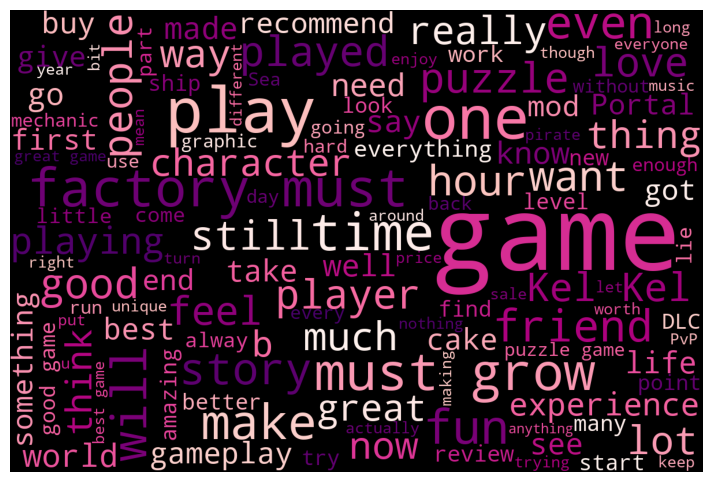

In [746]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

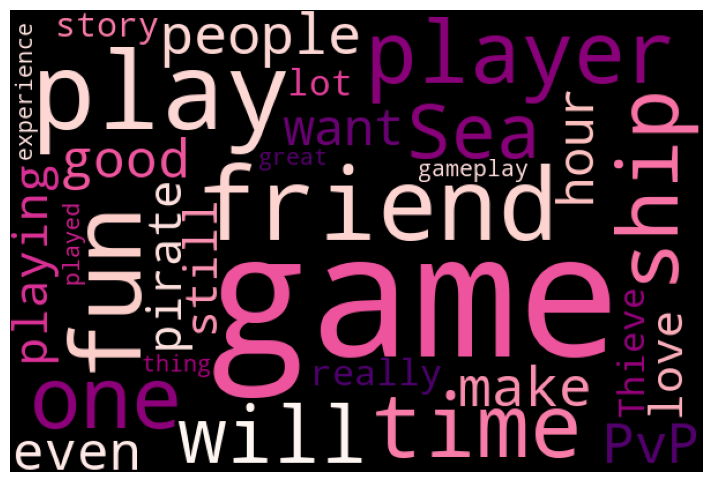

In [747]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

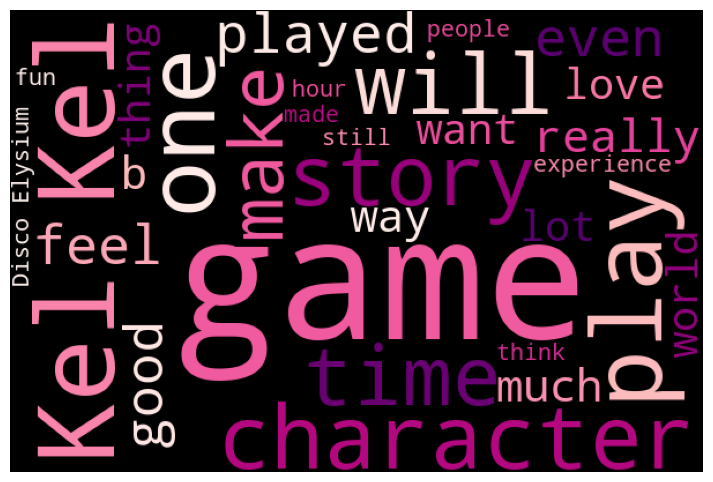

In [748]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

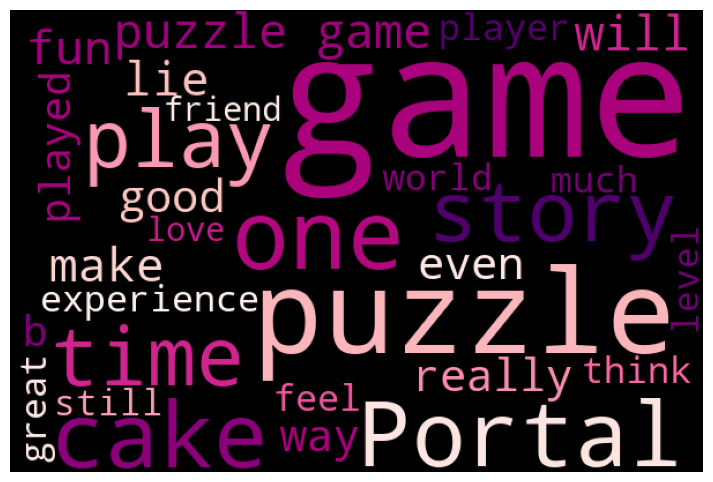

In [749]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

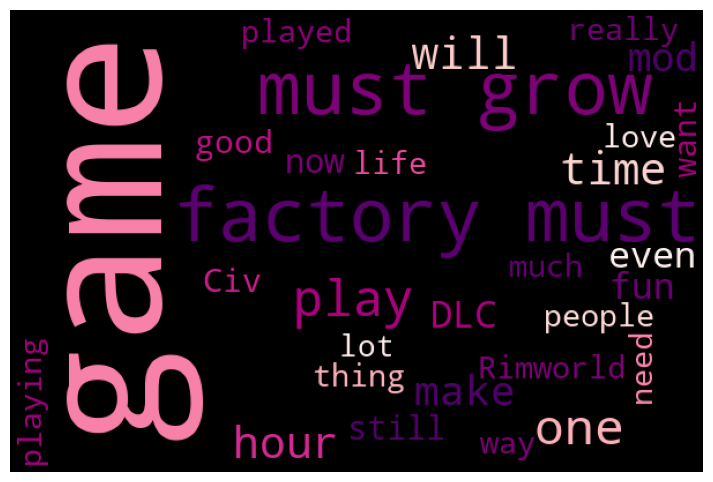

In [750]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [751]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [752]:
df["review"].sample(10)

25435    i review games on steam after i 100% complete ...
10954    i still think this game should be used in all ...
10817    i don't even notice the passage of time when p...
31112    do you believe in the heart of the cards?i sur...
9121     houndmaster: steady, girl. if we're called, we...
25236    hi, i'm markiplier. i make videos. from qualit...
28499                                         old man yaoi
2614      my 90 year old grandma could play it easy nor...
14702                such a good game highly recommend!!!!
8670                        i'm still waiting for season 2
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [753]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [754]:
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [755]:
df["review"].sample(5)

7431             slaps harder than an alcoholic stepfather
31191              time consuming and extremely addicting 
14135    rimworld is a colony builder sim with a scifi ...
30497    slay the spiremore like slay me spire hahahai ...
20109    after  hours in this game this is so far the b...
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [756]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [757]:
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [758]:
df["tokenized"].sample(15)

17120           [do, not, play, if, you, love, your, life]
2699     [great, game, for, playing, with, friends, esp...
8608     [why, oh, why, did, telltale, have, to, go, ba...
10460                                    [its, great, duh]
28076    [the, world, of, is, amazing, but, the, compan...
24573             [i, shoot, zombie, zombies, die, fun, d]
7737     [goddamn, phones, i, fucking, hate, these, thi...
4155     [shes, not, perfect, but, this, place, is, our...
561      [i, love, the, story, and, the, character, des...
2342     [it, was, outstandingly, enjoyable, when, i, b...
25480    [can, no, longer, play, this, trash, game, on,...
12272    [this, game, is, worth, at, most, of, its, cur...
15123                [definitely, not, a, waste, of, time]
20640    [if, youve, ever, wanted, a, full, time, job, ...
9308     [good, team, deadgood, tank, deadgood, player,...
Name: tokenized, dtype: object

### Stopwords

In [759]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [760]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [761]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [762]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [763]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [764]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_18532\2852639080.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = "pearson")


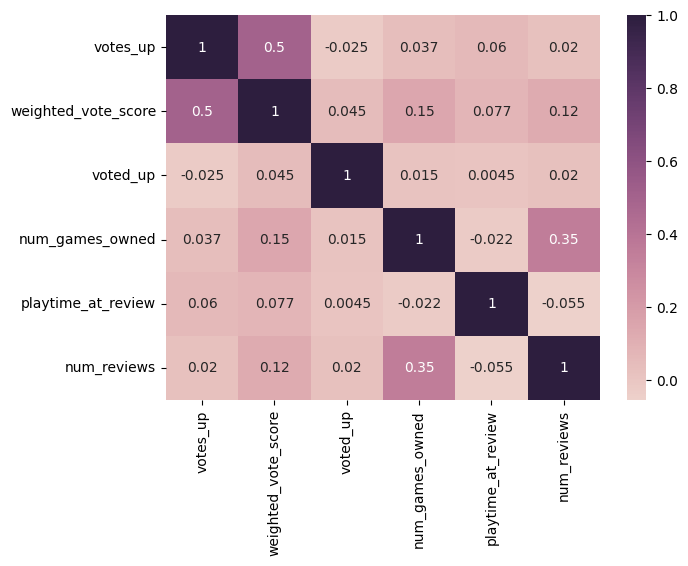

In [765]:
corr = df.corr(method = "pearson")
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

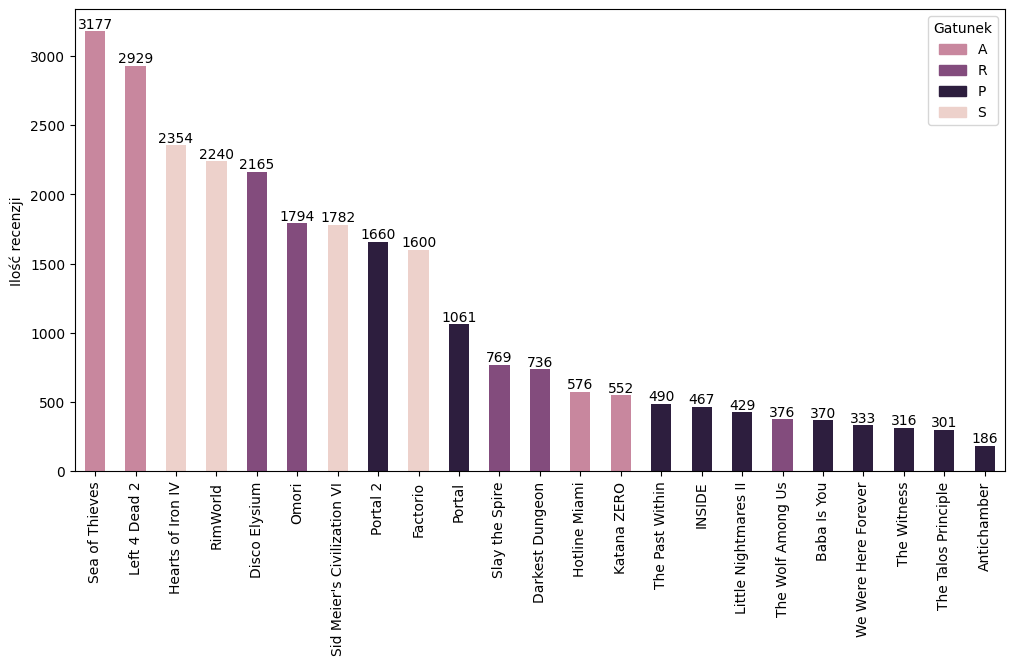

In [766]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

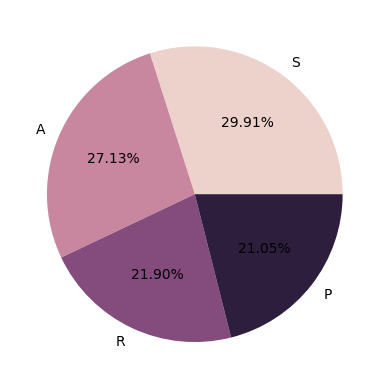

In [767]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

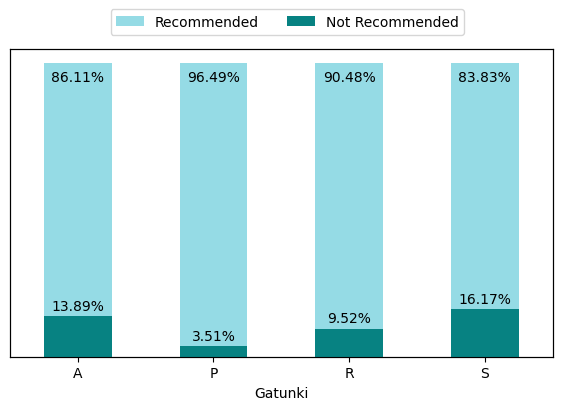

In [768]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

## Dependency parser test

In [769]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [770]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-05-21 15:25:35 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-21 15:25:35 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-05-21 15:25:36 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-05-21 15:25:36 INFO: Using device: cuda
2024-05-21 15:25:36 INFO: Loading: tokenize
2024-05-21 15:25:36 INFO: Loading: mwt
2024-05-21 15:25:36 INFO: Loading: pos
2024-05-21 15:25:37 INFO: Loading: lemma
2024-05-21 15:25:37 INFO: Loading: constituency
2024-05-21 15:25:37 INFO: Loading: depparse
2024-05-21 15:25:38 INFO: Loading: sentiment
2024-05-21 15:25:38 INFO: Loading: ne

In [771]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(*dependency_list[:20], sep='\n')

['crewing', 0, 'root']
['game', 'value', 'compound']
['value', 'crewing', 'obj']
['likely', 'crewing', 'advmod']
['worthless', 'crewing', 'xcomp']
['real', 'crewing', 'xcomp']
['but', 'play', 'cc']
['can', 'play', 'aux']
['play', 'crewing', 'conj']
['player', 'play', 'obj']
['but', 'want', 'cc']
['cant', 'want', 'aux']
['really', 'want', 'advmod']
['want', 'crewing', 'conj']
['like', 'graphics', 'discourse']
['game', 'fun', 'compound']
['fun', 'graphics', 'amod']
['graphics', 'want', 'obj']
['basic', 'want', 'xcomp']
['but', 'have', 'cc']


In [772]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS", "JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [796]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)

In [797]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [798]:
df = df[df["feature"].apply(lambda x: len(x) > 0)]

In [799]:
words = []
for i in df["feature"]:
    for j in i:
        words.append(j["feature"])

## Word embedding

## Correct misspeld words

## Similarity

### Word counts

In [800]:
unique_words = list(set(words))

In [801]:
word_counts = pd.DataFrame([[i, len([q for q in words if q==i])] for i in unique_words], 
              columns=['word', 'count']).sort_values('count', ascending=False)

## K-means

## Dendrogram

In [811]:
popular_words = word_counts[word_counts['count']>= 25]["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in popular_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

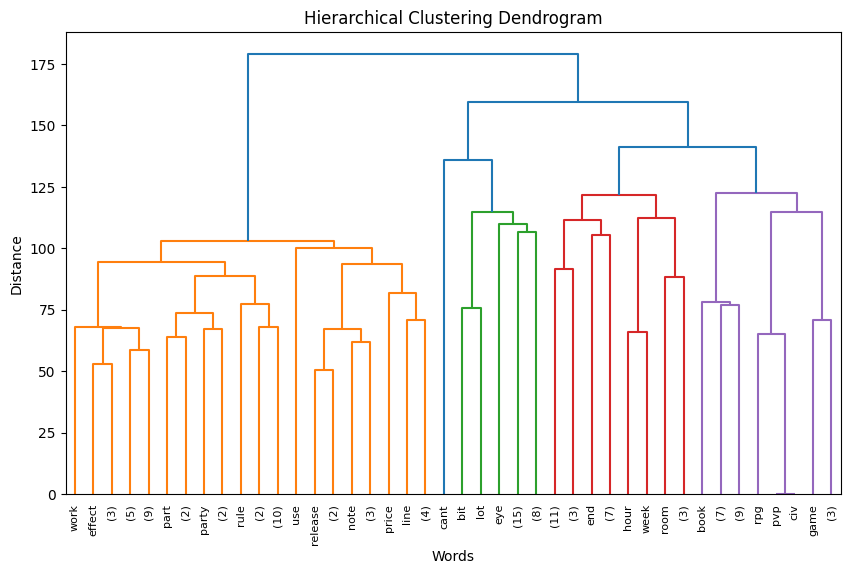

In [812]:
import pandas as pd
import spacy
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


Z = linkage(word_vectors.values, method='ward')

plt.figure(figsize=(10,6))
dendrogram(Z, p = 5, truncate_mode = "level", orientation='top', labels = popular_words, leaf_font_size = 8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('Distance')
plt.show()

In [813]:
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(Z, t = 78,  criterion="distance")

clusters = {}
for word, label in zip(popular_words, cluster_labels):
    if label not in clusters:
        clusters[label] = [word]
    else:
        clusters[label].append(word)

for label, words in clusters.items():
    print(f"Cluster {label}: {', '.join(words)}")

Cluster 32: game, player, play, playing
Cluster 29: puzzle, gameplay, character, graphic, quest, visual, concept, piece, horror, episode, figure, plot, genre, narrative, color, cutscene
Cluster 1: experience, content, work, community, playthrough, ending, element, effect, environment, civilization, encounter, requirement, landscape, balance, example, control, resource, cheater, change
Cluster 11: way, person, nothing, everything, feeling, emotion, everyone, word, voice, heart, kind
Cluster 26: hour, week
Cluster 9: world, life
Cluster 6: price
Cluster 14: fun
Cluster 5: level, point, line, number, class
Cluster 18: friend, pirate, grind, hero, boss, wolf, luck, loot, couple, rng
Cluster 4: review, update, feature, version, note, purchase, release
Cluster 2: part, place, event, party, leader, victory
Cluster 8: bit, lot
Cluster 31: pvp, civ, rpg
Cluster 3: challenge, problem, choice, reason, reward, question, rule, fact, progress, effort, chance, case, complaint
Cluster 25: end
Cluster 

In [814]:
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(Z, t=1, criterion="inconsistent")

clusters = {}
for word, label in zip(popular_words, cluster_labels):
    if label not in clusters:
        clusters[label] = [word]
    else:
        clusters[label].append(word)

for label, words in clusters.items():
    print(f"Cluster {label}: {', '.join(words)}")

Cluster 39: game, player, play, playing
Cluster 36: puzzle, gameplay, quest, piece, horror, episode, plot, genre, cutscene
Cluster 3: experience, content, community, element, environment, civilization, requirement, landscape, resource
Cluster 21: way
Cluster 17: person, nothing, everything, everyone
Cluster 33: hour, week
Cluster 35: character, graphic, visual, concept, figure, narrative, color
Cluster 15: world, life
Cluster 13: price, level, review, point, update, feature, line, version, use, number, note, purchase, class, release
Cluster 24: fun
Cluster 28: friend, hero, boss
Cluster 5: part, place, event
Cluster 14: bit, lot
Cluster 29: pirate, grind, wolf, luck, loot, couple, rng
Cluster 38: pvp, civ, rpg
Cluster 9: challenge, problem, question, complaint
Cluster 32: end, battle, combat, fight, crew, enemy, NASA, run
Cluster 34: lake, boat, room, water
Cluster 23: love, need, wish, hope
Cluster 4: work
Cluster 2: playthrough, ending, encounter, example, cheater
Cluster 30: bug
Clu

In [806]:
# 15, 24